# Data Mining for Business Analytics

## Dealing with text and Naive Bayes

Spring 2019 - Prof. George Valkanas

Material based on content courtesy of Prof. Foster Provost and Prof. Panos Ipeirotis

***


Following good practices, let's load the packages we'll use.

In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

# np.random.seed(36)

# We will want to keep track of some different roc curves, lets do that here
tprs = []
fprs = []
roc_labels = []


### Data
For this class, we have a new data set in `data/spam_ham.csv`. Let's take a look at what it contains.

Let's remember how to use the terminal (UNIX) commands for quick queries.

In [2]:
!head -3 data/spam_ham.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


Looks like we have two features: some text (looks like an email), and a label for spam or ham. What is the distribution of the target variable?

In [3]:
!cut -f2 -d',' data/spam_ham.csv | sort | uniq -c | head

'cut' is not recognized as an internal or external command,
operable program or batch file.


It doesn't look like that did what we wanted. Can you see why?

The data in this file is **text data**. The text data in the first column can have commas. The command line will have some issues reading this data since it will try to split on all instances of the delimeter. Ideally, we would like to have a way of **encapsulating** the first column. Note that we actually have something like this in the data. The first column is wrapped in single quotes. Python (and pandas) have more explicit ways of dealing with this:

In [4]:
data = pd.read_csv("data/spam_ham.csv", quotechar="'", escapechar="\\")

Above, we specify that fields that need to be encapsulated are done so with single quotes (`quotechar`). But, what if the text in this field uses single quotes? For example, apostrophes in words like "can't" would break the encapsulation. To overcome this, we **escape** single quotes that are actually just text. Here, we specify the escape character as a backslash (`escapechar`). So now, for example, "can't" would be written as "can\'t".

(Normally, this would involve slightly painful process of going through, finding the extra quotes, and escaping them.  A common way to find them would be to try to load the data, see where it breaks, fix the problem, and then iterate.  If there are just a few issues to fix, this can be effective.)

Let's take another look at our data.

In [5]:
data.head()

,text,spam
0,Hi...I have to use R to find out the 90% confi...,ham
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",ham
2,Stephen Thorne wrote:> What I was thinking was...,ham
3,"Hi,I have this site that auto generates an ind...",ham
4,Author: metzeDate: 2007-04-16 08:20:13 +0000 (...,ham


Here, the target is whether or not a record should be considered as spam. This is recorded as the string 'spam' or 'ham'. To make it a little easier for our classifier, let's recode it as `0` or `1`.

In [6]:
data['spam'] = pd.Series(data['spam'] == 'spam', dtype=int)

In [7]:
data.head()

,text,spam
0,Hi...I have to use R to find out the 90% confi...,0
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",0
2,Stephen Thorne wrote:> What I was thinking was...,0
3,"Hi,I have this site that auto generates an ind...",0
4,Author: metzeDate: 2007-04-16 08:20:13 +0000 (...,0


Since we are going to do some modeling, we should split our data into a training and test set.

In [8]:
X = data['text']  # These are the features
Y = data['spam']  # These are the labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

C:\Users\ashle\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Text as features
How can we turn the large amount of text for each record into useful features?


#### Binary representation
One way is to create a matrix that uses each word as a feature and keeps track of whether or not a word appears in a document/record. You can do this in sklearn with a `CountVectorizer()` and setting `binary` to `true`. The process is very similar to how you fit a model: you will fit a `CounterVectorizer()`. This will figure out what words exist in your data.

In [9]:
binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Let's look at the vocabulary the `CountVectorizer()` learned.

In [10]:
vocabulary_list = list(zip( binary_vectorizer.vocabulary_.keys(), binary_vectorizer.vocabulary_.values()) )

vocabulary_list[0:10]

[('hi', 32486),
 ('sachin', 53749),
 ('look', 39238),
 ('at', 14584),
 ('ufsj', 65245),
 ('symbol', 58955),
 ('it', 35835),
 ('unbelivable', 65403),
 ('looks', 39256),
 ('like', 38559)]

Now that we know what words are in the data, we can transform our blobs of text into a clean matrix. Simply `.transform()` the raw data using our fitted `CountVectorizer()`. You will do this for the training and test data. What do you think happens if there are new words in the test data that were not seen in the training data?

In [11]:
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

We can take a look at our new `X_test_counts`.

In [12]:
X_test_binary

<2028x70544 sparse matrix of type '<class 'numpy.int64'>'
	with 224379 stored elements in Compressed Sparse Row format>

Sparse matrix? Where is our data?

If you look at the output above, you will see that it is being stored in a *sparse* matrix (as opposed to the typical dense matrix) that is ~2k rows long and ~70k columns. The rows here are records in the original data and the columns are words. Given the shape, this means there are ~140m cells that should have values. However, from the above, we can see that only ~220k cells (~0.15%) of the cells have values! Why is this?

To save space, sklearn uses a sparse matrix. This means that only values that are not zero are stored! This saves a ton of space! This also means that visualizing the data is a little trickier. Let's look at a very small chunk.

In [13]:
X_test_binary[0:20, 0:20].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

#### Applying a model
Now that we have a ton of features (since we have a ton of words!) let's try using a logistic regression model to predict spam/ham.

In [14]:
model = LogisticRegression()
model.fit(X_train_binary, Y_train)

print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_binary)))

Area under the ROC curve on test data = 0.995


Is this any good? What do we care about in this case? Let's take a look at our ROC measure in more detail by looking at the actual ROC curve.

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_binary)[:,1])

#tprs.append(tpr)
#fprs.append(fpr)
#roc_labels.append("Default Binary")


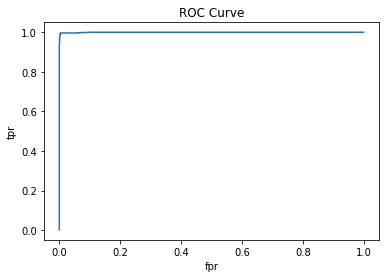

In [16]:

ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
#plt.yscale('log')
#plt.xscale('log')
plt.show()

 
**Take some time and review the curve. What do you think? Is it good? Is it bad?** 
***


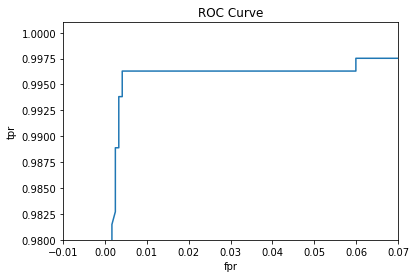

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_binary)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Binary")

ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([-0.01, .07])
plt.ylim([.98, 1.001])
plt.show()

#### Counts instead of binary
Instead of using a 0 or 1 to represent the occurence of a word, we can use the actual counts. We do this the same way as before, but now we leave `binary` set to `false` (the default value).

In [18]:
# Fit a counter
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

# Transform to counter
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_counts, Y_train)

print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_counts)))

Area under the ROC curve on test data = 0.993


We can also take a look at the ROC curve.

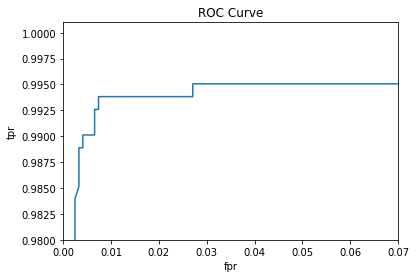

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_counts)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Counts")

ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, .07])
plt.ylim([.98, 1.001])

plt.show()

#### Tf-idf
Another popular technique when dealing with text is to use the term frequency - inverse document frequency (tf-idf) measure instead of just counts as the feature values (see text).

In [20]:
# Fit a counter
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform to a counter
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_tfidf, Y_train)

print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_counts)))

Area under the ROC curve on test data = 0.973


Once again, we can look at the ROC curve.

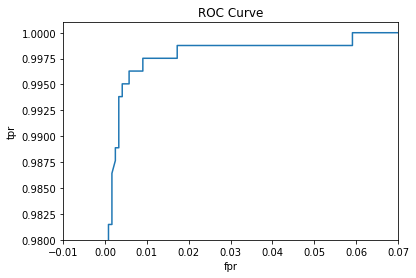

In [21]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_tfidf)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Tfidf")

ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")

plt.xlim([-0.01, .07])
plt.ylim([.98, 1.001])

plt.show()

The `CountVectorizer()` and `TfidfVectorizer()` functions have many options. You can restrict the words you would like in the vocabulary. You can add n-grams. You can use stop word lists. Which options you should use generally depend on the type of data you are dealing with. We can discuss and try some of them now.

Now that we have a few different feature sets and models, let's look at all of our ROC curves.

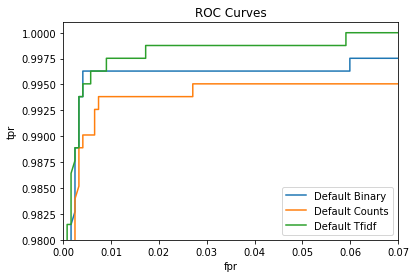

In [22]:
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()

plt.xlim([0, .07])
plt.ylim([.98, 1.001])

plt.show()

### Modeling with another technique: Naive Bayes

So far we have been exposed to tree classifiers and logistic regression in class. We have also seen SVM model in the homework. Now, it's time for another popular modeling technique of supervised learning(especially in text classification): the Naive Bayes (NB) classifier. In particular, we are using a Bernoulli Naive Bayes (BNB) for our binary classification. (Bernoulli NB is the model described in the book; there are other versions of NB, see below.)

As described in your text, the Naive Bayes model is a **probabilistic approach which assumes conditional independence between features** (in this case, each word is a feature, the conditioning is on the true class). It assigns class labels (e.g. spam = 1 or spam = 0). In other words, Naive Bayes models the probabilities of the presence of each _word_, given that we have a spam email, and given that we have a non-spam email.  Then it combines them using Bayes Theorem (again, as described in the book).

Using this model in sklearn works just the same as the others we've seen ([More details here..](http://scikit-learn.org/stable/modules/naive_bayes.html))

- Choose the model
- Fit the model (Train)
- Predict with the model (Train or Test or Use data)

In [23]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Naive Bayes has an alpha parameter, which operates exactly like the lambda parameter for Logistic Regression
model = BernoulliNB()
model.fit(X_train_counts, Y_train)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [24]:
print ("AUC on the count TRAIN data = %.3f" % metrics.roc_auc_score(Y_train, model.predict(X_train_counts)))
print ("AUC on the count TRAIN data = %.3f" % metrics.roc_auc_score(Y_train, model.predict_proba(X_train_counts)[:, 1]))

print ("AUC on the count TEST data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_counts)))
print ("AUC on the count TEST data = %.3f" % metrics.roc_auc_score(Y_test, model.predict_proba(X_test_counts)[:, 1]))

AUC on the count TRAIN data = 0.985
AUC on the count TRAIN data = 0.998
AUC on the count TEST data = 0.982
AUC on the count TEST data = 0.993


The past few weeks we have seen that many of the models we are using have different complexity control parameters that can be tweaked. In naive Bayes, the parameter that is typically tuned is the Laplace smoothing value **`alpha`**.

Also, there are other versions of naive Bayes:

1. **Multinomial naive Bayes (MNB):** This model handles count features and not just binary features. Sometimes MNB is used with binary presence/absence variables anyway (like word presence), even though that violates the model assumptions, because in practice it works well anyway.
2. **Gaussian Naive Bayes (GNB):** This model considers likelihood of the features as Gaussian--and thus we can use it for continuous features.  Sometimes GNB and Bernoulli NB are combined when one has features of mixed types.  

In [25]:
## Include the false positives and true positives to the previous list

fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_tfidf)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default BNB")


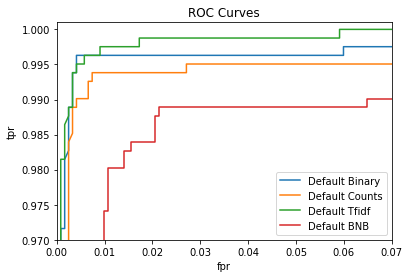

In [26]:

## Plot the list again: 3 Logistic Regressions vs Naive Bayes
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()

plt.xlim([0, .07])
plt.ylim([.97, 1.001])

plt.show()

In [27]:
# Fit a counter
count_vectorizer = CountVectorizer(ngram_range=(1,2))
count_vectorizer.fit(X_train)

# Transform to counter
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Model
model = BernoulliNB()
model.fit(X_train_counts, Y_train)

## Include the false positives and true positives to the previous list

fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_counts)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Bigram BNB")


print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_counts)))

Area under the ROC curve on test data = 0.984


Let's see what the features are in a bigram

In [28]:

for i, k in enumerate(zip(count_vectorizer.vocabulary_.keys(), count_vectorizer.vocabulary_.values())):
    print (k)
    if i >= 10:
        break

('hi', 178538)
('sachin', 317893)
('look', 223756)
('at', 67378)
('ufsj', 393819)
('symbol', 350003)
('it', 202751)
('unbelivable', 394533)
('looks', 223930)
('like', 218775)
('start', 341204)


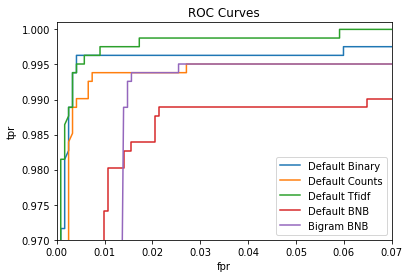

In [29]:

## Plot the list again: 3 Logistic Regressions vs Naive Bayes
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()

plt.xlim([0, .07])
plt.ylim([.97, 1.001])

plt.show()



### Extra Credit Assignment (5 points)

In the `data/` directory here, there is a zip file called `sentiment_analysis.zip`. The file contains two files: one called "training.txt" and another one called "testing.txt". Each file contains a number of lines. Each line is separated by a tab value. The first part of the line is a piece of text (a "review"). The second part of the ilne is a binary value, 0 or 1, indicating whether the review is negative (0) or positive (1).

Using code that you see in this notebook and, possibly, code from previous notebooks, do the following:

* Train 4 different classifiers on the contents of the "training.txt" file.
* Test each of the 4 different classifiers on the contents of the "testing.txt" file.


Evaluate your models as follows:
- Create an ROC plot that contains the curves of **all** the 4 different models, when focusing on predicting the positive class.
- Create an ROC plot that contains the curves of **all** the 4 different models, when focusing on predicting the negative class.

Make sure that in your plots you specify which model corresponds to which line.

Give a brief description of the results and say which model you would pick. 


**Deadline:** Sunday, March 31, 2019 11:59:59pm. I will create an assignment on Classes, where you can submit your results.